In [55]:
!pip install shap
!pip install lightgbm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.pipeline import FeatureUnion
import shap
import xgboost
# load JS visualization code to notebook
shap.initjs()

In [56]:
df = pd.read_csv("./bank.csv", ';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [57]:
df.rename(columns={'y':'target'}, inplace=True)
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [58]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [59]:
num_cols=df.select_dtypes(include=np.number).columns.tolist()
cat_cols=df.select_dtypes(object).columns.tolist()
print(f'Числовых признаков {len(num_cols)}, а именно:\n{num_cols}\n'
     f'\nКатегориальных признаков {len(cat_cols)}, а именно:\n{cat_cols}')

Числовых признаков 7, а именно:
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

Категориальных признаков 10, а именно:
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'target']


In [61]:
for i in cat_cols:
    unique_no = df[i].nunique()
    unique_name = df[i].unique().tolist()
    print(f'{i}, имеет {unique_no} уникальнх значения:\n{unique_name}\n')
    

job, имеет 12 уникальнх значения:
['unemployed', 'services', 'management', 'blue-collar', 'self-employed', 'technician', 'entrepreneur', 'admin.', 'student', 'housemaid', 'retired', 'unknown']

marital, имеет 3 уникальнх значения:
['married', 'single', 'divorced']

education, имеет 4 уникальнх значения:
['primary', 'secondary', 'tertiary', 'unknown']

default, имеет 2 уникальнх значения:
['no', 'yes']

housing, имеет 2 уникальнх значения:
['no', 'yes']

loan, имеет 2 уникальнх значения:
['no', 'yes']

contact, имеет 3 уникальнх значения:
['cellular', 'unknown', 'telephone']

month, имеет 12 уникальнх значения:
['oct', 'may', 'apr', 'jun', 'feb', 'aug', 'jan', 'jul', 'nov', 'sep', 'mar', 'dec']

poutcome, имеет 4 уникальнх значения:
['unknown', 'failure', 'other', 'success']

target, имеет 2 уникальнх значения:
['no', 'yes']



In [62]:
df['target'] = df['target'].replace('no', 0, regex=True)
df['target'] = df['target'].replace('yes', 1, regex=True)
df['default'] = df['default'].replace('no', 1, regex=True)
df['default'] = df['default'].replace('yes', 0, regex=True)
df['housing'] = df['housing'].replace('no', 0, regex=True)
df['housing'] = df['housing'].replace('yes', 1, regex=True)
df['loan'] = df['loan'].replace('no', 0, regex=True)
df['loan'] = df['loan'].replace('yes', 1, regex=True)


In [63]:
df.drop(['contact','day','month'], axis=1, inplace=True)
df

,age,job,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,poutcome,target
0,30,unemployed,married,primary,1,1787,0,0,79,1,-1,0,unknown,0
1,33,services,married,secondary,1,4789,1,1,220,1,339,4,failure,0
2,35,management,single,tertiary,1,1350,1,0,185,1,330,1,failure,0
3,30,management,married,tertiary,1,1476,1,1,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,1,0,1,0,226,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,1,-333,1,0,329,5,-1,0,unknown,0
4517,57,self-employed,married,tertiary,0,-3313,1,1,153,1,-1,0,unknown,0
4518,57,technician,married,secondary,1,295,0,0,151,11,-1,0,unknown,0
4519,28,blue-collar,married,secondary,1,1137,0,0,129,4,211,3,other,0


In [64]:
features = ['age', 'default', 'balance', 'housing', 'loan', 'duration', 'campaign','pdays','previous']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df['target'], random_state=0)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


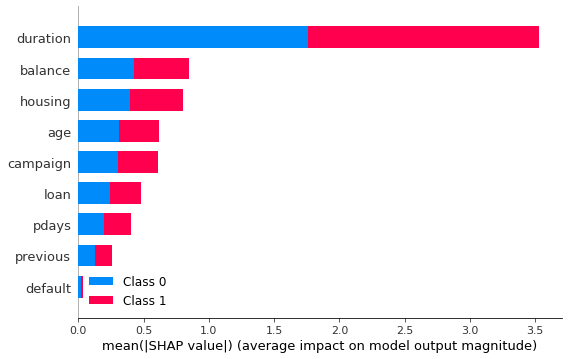

In [66]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(random_state=1)
lgb_model.fit(X_train, y_train)

y_preds = lgb_model.predict(X_test)

# строим модель объяснения в SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

# покажем объяснение
shap.initjs() # для работы в колабе
shap.summary_plot(shap_values, X_test)

Explained expected value: [[-0.13912733 -0.00770441 -0.7277376  ... -0.01291774 -0.07558194
  -0.09691896]
 [-0.40924385 -0.00810161 -0.79643698 ... -0.18416938 -0.05520973
  -0.0728622 ]
 [-0.27636995 -0.00855308 -0.80453257 ...  0.21559542 -0.0248175
  -0.1148    ]
 ...
 [-0.19010681 -0.00873598  0.53525764 ... -2.22697005 -0.10107211
  -0.09023412]
 [-0.28956465 -0.00728448 -0.32011016 ... -0.03673327 -0.04248413
  -0.02905789]
 [-0.25114587 -0.0057192   1.18022217 ... -0.26734937 -0.14336403
  -0.04840143]]


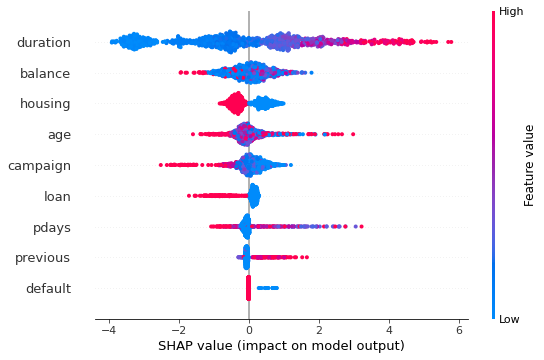

In [67]:
if isinstance(shap_values, list):
    shap_values = shap_values[1]

print(f'Explained expected value: {shap_values}')

shap.summary_plot(shap_values, X_test)

Из графика видно, что наибольшее значение на target, то есть на то что клиент оформит срочный вклад оказывает показатель duration, и чем он выше,тем выше вероятность того что клиент согласится, также можем сделать вывод что если duration=0 ,клиент точно откажется от депозита.
Отсутвие просрочки, наличие займа на дом и наличие обычного займа будет положительно влиять на решение офрмить срочный вклад.Также весомый вклад имеет возраст, чем выше,тем вероятнее человек согласится.показатель pdays также имеет хорошее влияниею


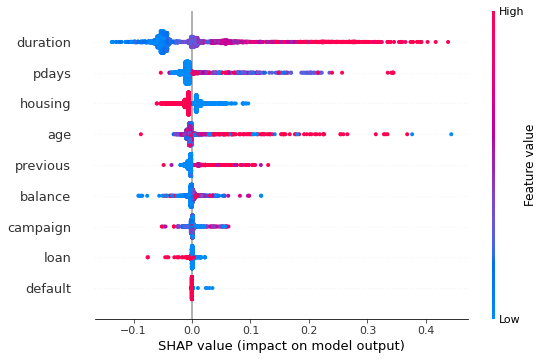

In [68]:
model = xgboost.train({"learning_rate": 0.01, 'random_state': 1}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values_all = explainer.shap_values(X_train)

shap.summary_plot(shap_values_all, X_train)

In [ ]:
в целом показатели влияния те же, но здесь показатели age и pdays оказывают большее влияние, чем в прошлой модели.

In [69]:
shap.initjs()
idx = 1
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], X_train.iloc[idx,:])

Для данного объекта вероятность оформления срочного депозита составляет 0.19, то есть маловероятно что он оформит депозит, на это влияет показатель низкий duration, отсуттсвие займа на дом,возраст

In [70]:
shap.initjs()
idx = 10
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], X_train.iloc[idx,:])

Для данного объекта вероятность оформления срочного депозита составляет 0.24, то есть маловероятно что он оформит депозит, даже не смотря на баланс и наличие займа на дом, другие показатели тянут его вниз, также duration не высокий.

In [71]:
shap.initjs()
idx = 350
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], X_train.iloc[idx,:])

Для данного объекта вероятность оформления срочного депозита составляет 0.51,скорее всего он согласится на депозит, на это влияет наличие займа на дом и  высокий показатель duration 